In [ ]:
# Kimlik Doğrulama.
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


# YAMNet ile ses sınıflandırılması

* YAMNet, 521 ses olayını tahmin edebilen derin bir ağdır.(https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv) 
* http://g.co/audioset üzerinde eğitilmiştir.
* Model için detaylı bilgi almak istiyorsanız https://arxiv.org/pdf/1704.04861.pdf

In [ ]:
# ilgili kütüphanelerin kurulması
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile

In [ ]:
# modelin yüklenmesi
model = hub.load('https://tfhub.dev/google/yamnet/1')

In [ ]:
def class_names_from_csv(class_map_csv_text):
  
  class_names = []
  with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      class_names.append(row['display_name'])

  return class_names

class_map_path = model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)

In [ ]:
def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=16000):
  
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) /
                               original_sample_rate * desired_sample_rate))
    waveform = scipy.signal.resample(waveform, desired_length)
  return desired_sample_rate, waveform

## Ses dosyasının yüklenmesi.

* Burada bir wav dosyası indirecek ve dinleyeceksiniz.
Zaten mevcut bir dosyanız varsa, dosyayı colab'a yükleyin ve bunun yerine kullanın.
* Not: Beklenen ses dosyası 16kHz örnekleme hızında bir mono wav dosyası olmalıdır.

In [ ]:
# wav_file_name = 'speech_whistling2.wav'
import scipy
wav_file_name = '/gdrive/My Drive/Calisma_ortami/Uygulamalar/bebikk.wav'
sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')
sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

duration = len(wav_data)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(wav_data)}')

# yüklediğimiz dosyayı dinleyelim.
Audio(wav_data, rate=sample_rate)

Sample rate: 16000 Hz
Total duration: 11.31s
Size of the input: 180976


In [ ]:
waveform = wav_data / tf.int16.max

## Modelin çalıştırılması ve değerlerin alınması


In [ ]:
scores, embeddings, spectrogram = model(waveform)

In [ ]:
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = class_names[scores_np.mean(axis=0).argmax()]
print(f'En yüksek tahminim : {infered_class}')

En yüksek tahminim : Silence


## Görselleştirme


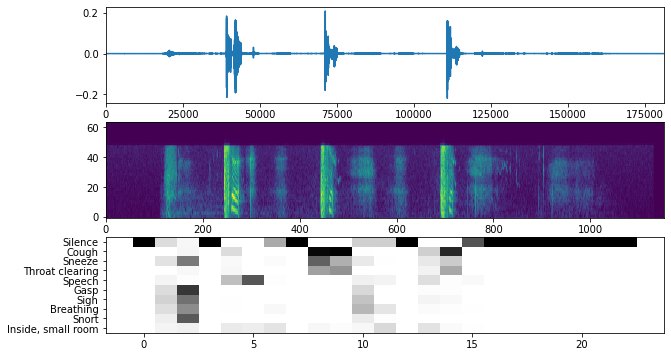

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])

yticks = range(0, top_n, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))

Görüldüğü üzere modelimiz gayet başarılı bir tanıma işlemi yaptı. İlgili wav dosyasındaki sesin öksürük ya da hapşırma olabileceğini tahmin etti.